# Visualization of Raw Gaze Data 

__UbiComp Assignment 02, Task 01:__
This first notebook allows you to explore the raw gaze data that is collected from Microsoft HoloLens2.

Parts of this code are taken from a tutorial from Pupil Labs. See Section 1&2 in their [repository](https://github.com/pupil-labs/pupil-tutorials/blob/master/01_load_exported_data_and_visualize_pupillometry.ipynb).

## Read eye tracking data from a csv-file.

In [2]:
import os
import pandas as pd

hololens_pd_frame = pd.read_csv('Data/RawGazeData/01_Reading.csv')

## Column names
Here you see all the column names of the tabular data in the csv-file. \
Please refer to [/AR-Eye-Tracking-Toolkit/ARETT](https://github.com/AR-Eye-Tracking-Toolkit/ARETT/wiki/Log-Format) for more details (e.g., the data stored in the columns)

In [3]:
print("The csv file contains columns of:")
list(hololens_pd_frame.columns)

The csv file contains columns of:


['eyeDataTimestamp',
 'eyeDataRelativeTimestamp',
 'frameTimestamp',
 'isCalibrationValid',
 'gazeHasValue',
 'gazeOrigin_x',
 'gazeOrigin_y',
 'gazeOrigin_z',
 'gazeDirection_x',
 'gazeDirection_y',
 'gazeDirection_z',
 'gazePointHit',
 'gazePoint_x',
 'gazePoint_y',
 'gazePoint_z',
 'gazePoint_target_name',
 'gazePoint_target_x',
 'gazePoint_target_y',
 'gazePoint_target_z',
 'gazePoint_target_pos_x',
 'gazePoint_target_pos_y',
 'gazePoint_target_pos_z',
 'gazePoint_target_rot_x',
 'gazePoint_target_rot_y',
 'gazePoint_target_rot_z',
 'gazePoint_target_scale_x',
 'gazePoint_target_scale_y',
 'gazePoint_target_scale_z',
 'gazePointLeftScreen_x',
 'gazePointLeftScreen_y',
 'gazePointLeftScreen_z',
 'gazePointRightScreen_x',
 'gazePointRightScreen_y',
 'gazePointRightScreen_z',
 'gazePointMonoScreen_x',
 'gazePointMonoScreen_y',
 'gazePointMonoScreen_z',
 'GazePointWebcam_x',
 'GazePointWebcam_y',
 'GazePointWebcam_z',
 'gazePointAOIHit',
 'gazePointAOI_x',
 'gazePointAOI_y',
 'gazePoin

# How does the data look?

In [4]:
from IPython.display import display

# Look for valid data only
detector_3d_data = hololens_pd_frame[hololens_pd_frame.gazeHasValue == True]

# Skip the first 5 seconds of the recording
start_time = detector_3d_data.eyeDataTimestamp.iloc[0] + 5
detector_3d_data = detector_3d_data[detector_3d_data.eyeDataTimestamp > start_time]

# Show some selected columns
print("Eye tracking data:")
display(detector_3d_data[['eyeDataTimestamp', 'gazeHasValue', 'gazeOrigin_x', 'gazeOrigin_y', 'gazeOrigin_x']].head(10))



Eye tracking data:


,eyeDataTimestamp,gazeHasValue,gazeOrigin_x,gazeOrigin_y,gazeOrigin_x
1,1660743976560,True,0.00688,0.06962,0.00688
2,1660743976594,True,0.00616,0.06952,0.00616
3,1660743976627,True,0.00529,0.06944,0.00529
4,1660743976660,True,0.00506,0.06944,0.00506
5,1660743976694,True,0.00494,0.06947,0.00494
6,1660743976727,True,0.00470,0.06947,0.00470
7,1660743976760,True,0.00399,0.06940,0.00399
8,1660743976794,True,0.00281,0.06946,0.00281
9,1660743976827,True,0.00191,0.06958,0.00191
10,1660743976860,True,0.00132,0.06972,0.00132


## Gaze Direction over time
This plot visualizes the `gazeDirection_x`and `gazeDirection_y` over time.

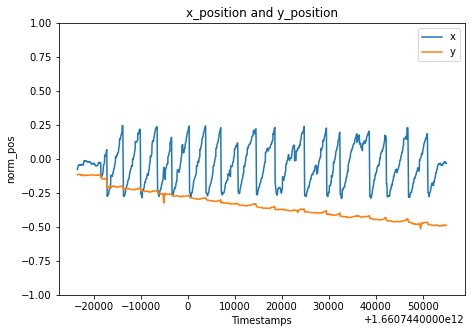

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))

# Plot eye position X
plt.subplot(1, 2, 1)
plt.plot(detector_3d_data['eyeDataTimestamp'], detector_3d_data['gazeDirection_x'])
# Plot eye position Y
plt.plot(detector_3d_data['eyeDataTimestamp'], detector_3d_data['gazeDirection_y'])
plt.xlabel('Timestamps')
plt.ylabel('norm_pos')
plt.ylim([-1, 1])
plt.title('x_position and y_position')
plt.legend("xy")

## Saccades

This plot visualizes the velocity of the `gazeDirection_x` values. A high velocity (i.e., a peak in the plot) indicates a (possible) saccade.

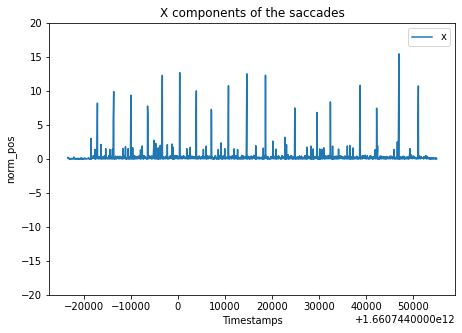

In [6]:
plt.figure(figsize=(16, 5))

# Plot the peak velocities for X
plt.subplot(1, 2, 1)
plt.plot(detector_3d_data['eyeDataTimestamp'], ( abs(detector_3d_data['gazeDirection_x'].diff()) / 0.033) )
plt.xlabel('Timestamps')
plt.ylabel('norm_pos')
plt.ylim([-20, 20])
plt.title('X components of the saccades')
plt.legend("xy")

## Gaze Position 
This plot shows the gaze positions for the 'reading' activity. The lines of the read text are clearly visible. The color denotes the timestamp for each point.

Text(0.5, 1.0, 'Gaze Position')

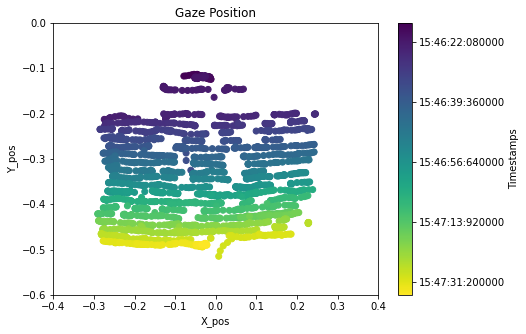

In [7]:
import matplotlib.dates as md
import datetime as dt

plt.figure(figsize=(16, 5))

dates=[dt.datetime.fromtimestamp(ts) for ts in detector_3d_data['eyeDataTimestamp']/1000]
datenums=md.date2num(dates)

# plot gaze
plt.subplot(1, 2, 1)
plt.scatter(detector_3d_data['gazeDirection_x'], detector_3d_data['gazeDirection_y'], c=datenums)
xfmt = md.DateFormatter('%H:%M:%S:%f')
c = plt.colorbar()
c.ax.yaxis.set_major_formatter(xfmt)
c.ax.set_ylabel('Timestamps')
c.ax.invert_yaxis()
plt.xlabel('X_pos')
plt.ylabel('Y_pos')
plt.xlim([-0.4, 0.4])
plt.ylim([-0.6, 0])
plt.title('Gaze Position')

## Fixations
The following cells calculate the fixations of the given raw gaze data.

In [8]:
import numpy as np
import scipy.spatial.distance

def vector_dispersion(vectors):
    distances = scipy.spatial.distance.pdist(vectors, metric='cosine')
    distances.sort()
    cut_off = np.max([distances.shape[0] // 5, 4])
    return np.arccos(1. - distances[-cut_off:].mean())

In [9]:
max_dispersion = np.deg2rad(1)
min_duration = 0.4

In [10]:
def gaze_dispersion(eye_data):
 
    vectors = []
    for p in eye_data:
        vectors.append((p['gazeDirection_x'], p['gazeDirection_y'], p['gazeDirection_z']))
    vectors = np.array(vectors, dtype=np.float32)

    if len(vectors) < 2:
        return float("inf")
    else:
        return vector_dispersion(vectors)

In [11]:
def get_centroid(eye_data):
    x = [p['gazeDirection_x'] for p in eye_data]
    y = [p['gazeDirection_y'] for p in eye_data]
    z = [p['gazeDirection_z'] for p in eye_data]
    return (sum(x) / len(eye_data), sum(y) / len(eye_data), sum(z) / len(eye_data))

In [12]:
from collections import deque

def detect_fixations(gaze_data):
    # Convert Pandas data frame to list of Python dictionaries
    gaze_data = gaze_data.T.to_dict().values()

    candidate = deque()
    future_data = deque(gaze_data)
    while future_data:
        # check if candidate contains enough data
        if len(candidate) < 2 or candidate[-1]['eyeDataTimestamp'] - candidate[0]['eyeDataTimestamp'] < min_duration:
            datum = future_data.popleft()
            candidate.append(datum)
            continue

        # Minimal duration reached, check for fixation
        dispersion = gaze_dispersion(candidate)
        if dispersion > max_dispersion:
            # not a fixation, move forward
            candidate.popleft()
            continue

        # Minimal fixation found. Try to extend!
        while future_data:
            datum = future_data[0]
            candidate.append(datum)

            dispersion = gaze_dispersion(candidate)
            if dispersion > max_dispersion:
                # end of fixation found
                candidate.pop()
                break
            else:
                # still a fixation, continue extending
                future_data.popleft()
       
        centroid = get_centroid(candidate)
        yield {"start": candidate[0]['eyeDataTimestamp'], "end": candidate[-1]['eyeDataTimestamp'],
               "duration": candidate[-1]['eyeDataTimestamp'] - candidate[0]['eyeDataTimestamp'],
              "centroid": centroid}
        candidate.clear()

In [13]:
%time fixations = list(detect_fixations(detector_3d_data))

CPU times: total: 203 ms
Wall time: 216 ms


### One way of plotting the Fixations:

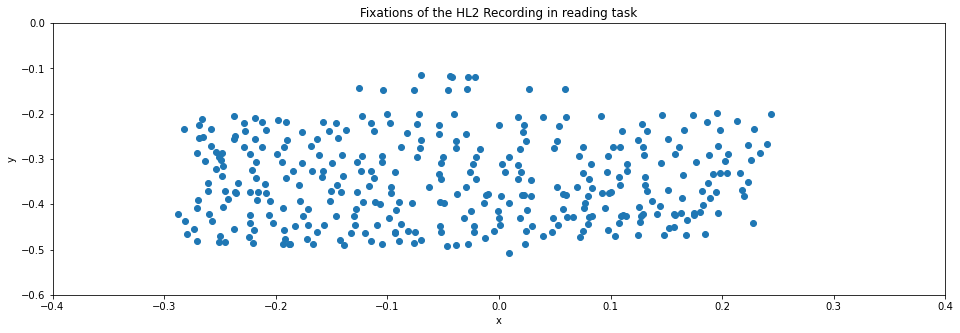

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

x_val = []
y_val = []
z_val = []
for fix in fixations:
    x_val.append(fix["centroid"][0])
    y_val.append(fix["centroid"][1])
    z_val.append(fix["centroid"][2])
    
fig = plt.figure(figsize=(16, 5))
# ax = plt.axes(projection ="3d")
plt.scatter(x_val, y_val)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-0.4, 0.4])
plt.ylim([-0.6, 0])
plt.title('Fixations of the HL2 Recording in reading task')
plt.show()

### Fixation duration can be represented by the color *(c)* or size *(s)* of each point 

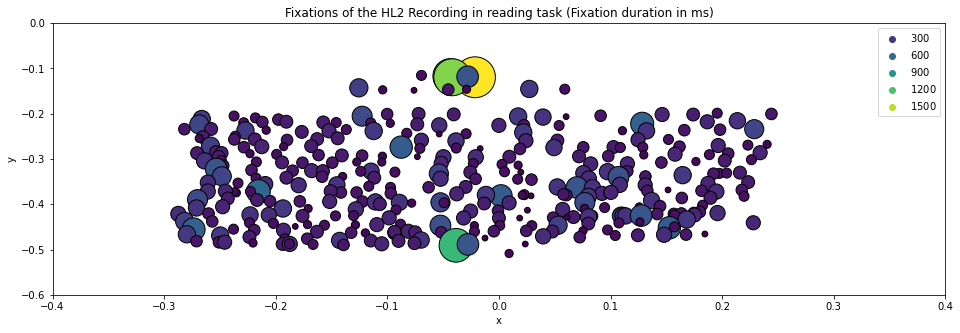

In [14]:
x_val = []
y_val = []
z_val = []
duration = []
for fix in fixations:
    x_val.append(fix["centroid"][0])
    y_val.append(fix["centroid"][1])
    z_val.append(fix["centroid"][2])
    duration.append(fix["duration"])
    
fig = plt.figure(figsize=(16, 5))
sc = plt.scatter(x_val, y_val, c=duration, s=duration, edgecolors='black')
plt.legend(*sc.legend_elements("colors", num=5))
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([-0.4, 0.4])
plt.ylim([-0.6, 0])
plt.title('Fixations of the HL2 Recording in reading task (Fixation duration in ms)')
plt.show()

## End of the notebook.